In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [2]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZRVATN/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZRVATN/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()['label']

2

# **Visualize Data**

In [31]:
import numpy as np

In [8]:
dataiterator = ds.as_numpy_iterator()

**Squeeze the image from (28,28,1) to (28,28)**

In [14]:
dataiterator.next()['image'].shape

(28, 28, 1)

In [15]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

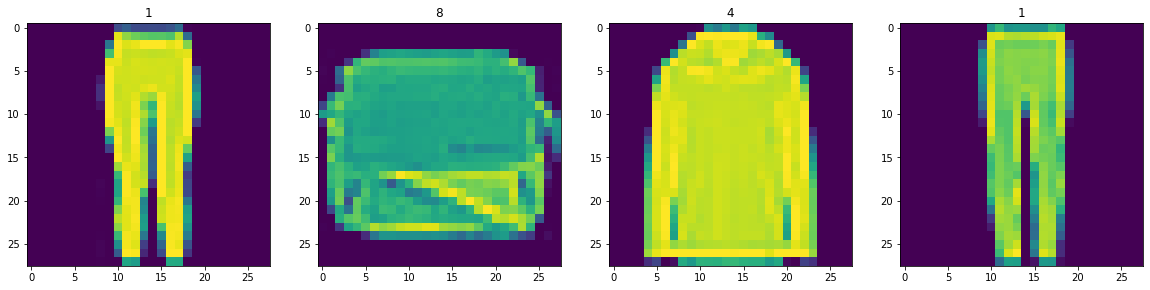

In [10]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [11]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

# **Pipeline**

1.   map
2.   cache
3.  shuffle
4.  batch
5.  prefetch



In [12]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [16]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# **Build the model**

In [17]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

**generator input: 128 random values, output 28x28x1 image**

In [35]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [36]:
generator = build_generator()

In [37]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [54]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
img.shape

(4, 28, 28, 1)

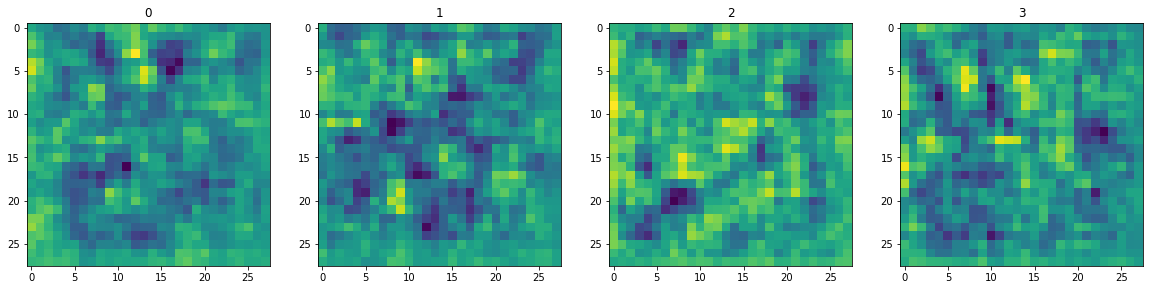

In [55]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

**discriminator input 28x28x1 image, output: 0 to 1** 

In [39]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [40]:
discriminator = build_discriminator()

In [41]:

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [72]:
img = generator.predict(np.random.randn(4,128,1))

In [73]:
img.shape

(4, 28, 28, 1)

In [74]:
discriminator.predict(img)

array([[0.50043637],
       [0.5006167 ],
       [0.500685  ],
       [0.50052834]], dtype=float32)

# **Training Loop**

In [75]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [76]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [77]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [78]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [79]:
fashgan = FashionGAN(generator, discriminator)

In [80]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

# **Callbacks**

In [81]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
img.shape

(4, 28, 28, 1)

In [93]:
img=img[0]
img.shape

(28, 28, 1)

In [95]:
img=array_to_img(img)

In [96]:
img

In [98]:
img.save('/content/drive/My Drive/Colab Notebooks/GAN/images/test.png')

In [101]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/My Drive/Colab Notebooks/GAN/images', f'generated_img_{epoch}_{i}.png'))

# **Train**

In [102]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:08 - d_loss: 0.2859 - g_loss: 2.6142WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0707s vs `on_train_batch_end` time: 0.0824s). Check your callbacks.


469/469 [==============================] - 74s 158ms/step - d_loss: 0.2783 - g_loss: 2.6100
Epoch 2/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2745 - g_loss: 2.6479
Epoch 3/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2733 - g_loss: 2.6594
Epoch 4/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2720 - g_loss: 2.6513
Epoch 5/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2710 - g_loss: 2.6482
Epoch 6/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2700 - g_loss: 2.6455
Epoch 7/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.2697 - g_loss: 2.6396
Epoch 8/20
469/469 [==============================] - 73s 157ms/step - d_loss: 0.2695 - g_loss: 2.6417
Epoch 9/20
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2687 - g_loss: 2.6501
Epoch 10/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.26

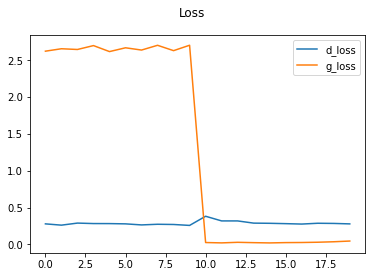

In [103]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [104]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [106]:
generator.load_weights('generator.h5')

In [107]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [109]:
imgs.shape

(16, 28, 28, 1)

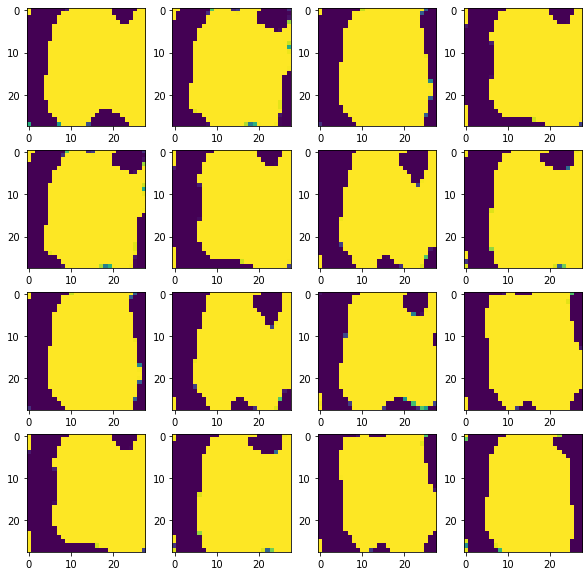

In [112]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(np.squeeze(imgs[(r+1)*(c+1)-1]))